### 0. Introduction to Reinformcement Learning

Simple example to see how the elements of RL (policy, states, actions, reward, value...) change in a simple environment to further undestanding

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define a simple 4x4 GridWorld environment.
class GridWorld:
    def __init__(self):
        self.size = 4                # 4x4 grid.
        self.start = (0, 0)          # Start at top-left corner.
        self.goal = (3, 3)           # Goal at bottom-right corner.
        self.state = self.start

    def reset(self):
        """Reset the environment to the starting state."""
        self.state = self.start
        return self.state

    def step(self, action):
        """
        Take an action and update the state.
        Actions: 0=up, 1=down, 2=left, 3=right.
        """
        x, y = self.state
        if action == 0:  # up
            new_state = (max(x - 1, 0), y)
        elif action == 1:  # down
            new_state = (min(x + 1, self.size - 1), y)
        elif action == 2:  # left
            new_state = (x, max(y - 1, 0))
        elif action == 3:  # right
            new_state = (x, min(y + 1, self.size - 1))
        else:
            new_state = self.state

        self.state = new_state
        
        # Reward: +10 when reaching goal, -1 for each move.
        if new_state == self.goal:
            reward = 10
            done = True
        else:
            reward = -1
            done = False
        return new_state, reward, done

# Define a simple Deep Q-Network (DQN) Agent.
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        """Build a small neural network with a single hidden layer."""
        model = Sequential()
        model.add(Dense(8, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def predict(self, state):
        """Predict values for a given state."""
        return self.model.predict(state, verbose=0)

    def train(self, state, target):
        """Train the model on one sample."""
        self.model.fit(state, target, epochs=1, verbose=0)

# Initialize the environment and agent.
env = GridWorld()
state_size = 2    # State is (x, y) coordinates.
action_size = 4   # Four actions: up, down, left, right.
agent = DQNAgent(state_size, action_size)

# Training parameters
episodes = 200      # Number of episodes.
max_steps = 20      # Number of steps per episode.
gamma = 0.90        # Discount factor.
epsilon = 1.0       # Initial exploration rate.
epsilon_min = 0.1   # Minimum exploration rate.
epsilon_decay = 0.98  # Faster decay for epsilon.

# Data tracking for visualizations.
state_visits = np.zeros((env.size, env.size))  # To count state visits.
exploration_counts = []  # Exploration moves per episode.
exploitation_counts = [] # Exploitation moves per episode.
action_counts = np.zeros(action_size)  # Frequency of each action.
episode_rewards = []  # Total reward per episode.

# Training loop.
for episode in range(episodes):
    state = env.reset()
    # Normalize state coordinates.
    s = np.array([[state[0] / (env.size - 1), state[1] / (env.size - 1)]])
    done = False
    exp_count = 0
    explo_count = 0
    total_reward = 0  # Track total reward for this episode.
    
    for step in range(max_steps):
        # Record state visit.
        state_visits[state[0], state[1]] += 1
        
        # Choose an action using ε‑greedy strategy.
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
            exp_count += 1
        else:
            q_values = agent.predict(s)
            action = np.argmax(q_values[0])
            explo_count += 1
        
        action_counts[action] += 1
        
        # Take the action.
        next_state, reward, done = env.step(action)
        total_reward += reward  # Accumulate reward.
        s_next = np.array([[next_state[0] / (env.size - 1), next_state[1] / (env.size - 1)]])
        
        # Value update.
        target = agent.predict(s)
        if done:
            target[0][action] = reward
        else:
            t = agent.predict(s_next)
            target[0][action] = reward + gamma * np.amax(t[0])
        
        # Train the network to learn the value.
        agent.train(s, target)
        s = s_next
        state = next_state
        
        if done:
            break

    # Decay epsilon after each episode.
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    exploration_counts.append(exp_count)
    exploitation_counts.append(explo_count)
    episode_rewards.append(total_reward)  # Record total reward for this episode.

c:\Users\imcir\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


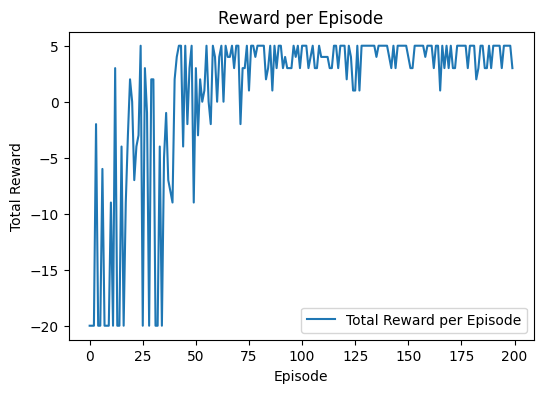

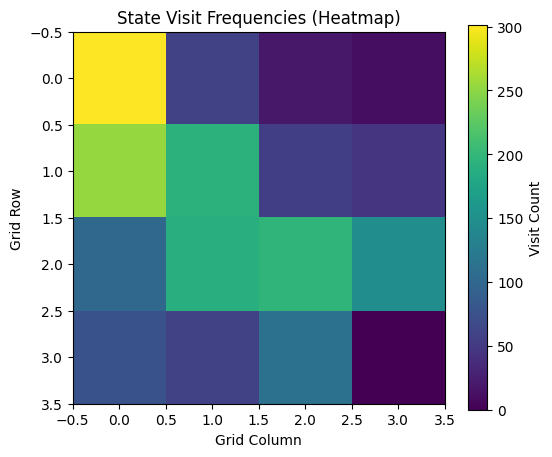

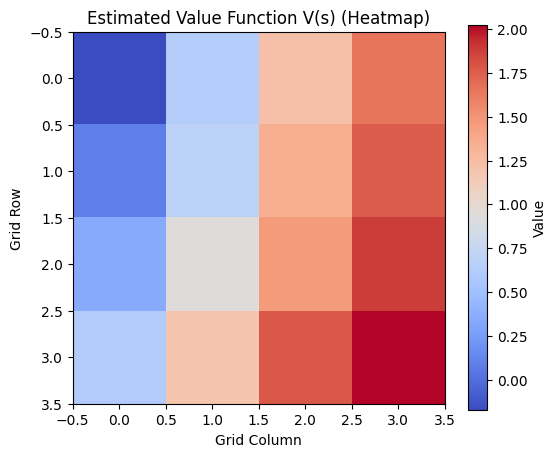

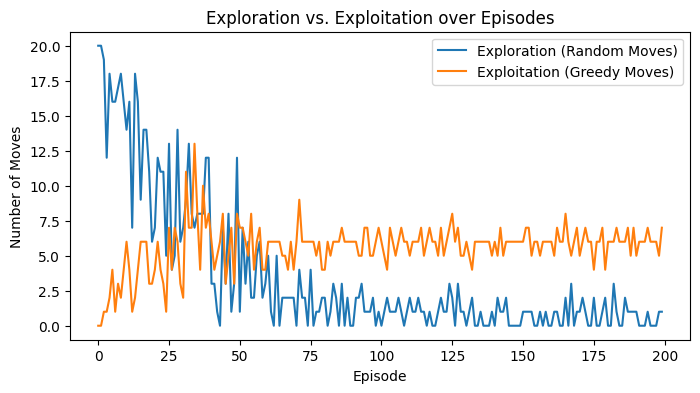

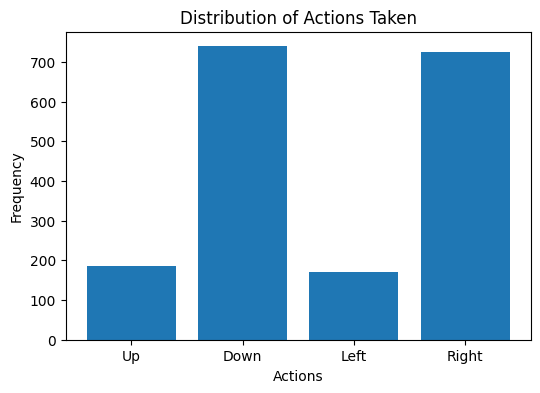

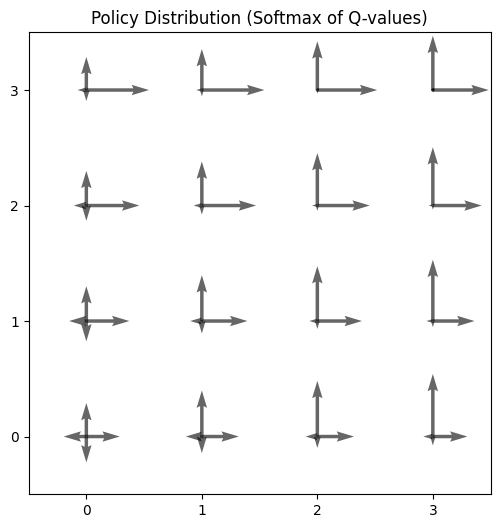

In [3]:
episodes_range = np.arange(episodes)

# 1. Plot: Reward per Episode.
plt.figure(figsize=(6, 4))
plt.plot(episodes_range, episode_rewards, label='Total Reward per Episode')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode")
plt.legend()
plt.show()

# 2. Plot: Distribution of State Visits (Heatmap).
plt.figure(figsize=(6, 5))
plt.imshow(state_visits, cmap='viridis', origin='upper')
plt.title('State Visit Frequencies (Heatmap)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')
plt.colorbar(label='Visit Count')
plt.show()

# 3. Plot: Estimated Value Function V(s) (Heatmap).
value_function = np.zeros((env.size, env.size))
for i in range(env.size):
    for j in range(env.size):
        state_norm = np.array([[i / (env.size - 1), j / (env.size - 1)]])
        q_vals = agent.predict(state_norm)
        value_function[i, j] = np.max(q_vals[0])
plt.figure(figsize=(6, 5))
plt.imshow(value_function, cmap='coolwarm', origin='upper')
plt.title('Estimated Value Function V(s) (Heatmap)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')
plt.colorbar(label='Value')
plt.show()

# 4. Plot: Exploration vs. Exploitation Counts per Episode.
plt.figure(figsize=(8, 4))
plt.plot(episodes_range, exploration_counts, label='Exploration (Random Moves)')
plt.plot(episodes_range, exploitation_counts, label='Exploitation (Greedy Moves)')
plt.title('Exploration vs. Exploitation over Episodes')
plt.xlabel('Episode')
plt.ylabel('Number of Moves')
plt.legend()
plt.show()

# 5. Plot: Distribution of Actions Taken.
actions = ['Up', 'Down', 'Left', 'Right']
plt.figure(figsize=(6, 4))
plt.bar(actions, action_counts)
plt.title('Distribution of Actions Taken')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.show()

# 6. Plot: Policy visualization.
def softmax(q_values, temperature=1.0):
    """Compute a softmax distribution over Q-values for visualization."""
    exps = np.exp(q_values / temperature)
    return exps / np.sum(exps)

# Directions for each action: up=0, down=1, left=2, right=3.
directions = {
    0: (0, -1),  # up
    1: (0, 1),   # down
    2: (-1, 0),  # left
    3: (1, 0)    # right
}

# Create a figure.
plt.figure(figsize=(6, 6))

# We will place arrows at the center of each cell.
# For a 4x4 grid, i goes from 0 to 3 (row), j goes from 0 to 3 (column).
X, Y = np.meshgrid(np.arange(env.size), np.arange(env.size))

for i in range(env.size):
    for j in range(env.size):
        # Normalize state coordinates as before.
        s_norm = np.array([[i / (env.size - 1), j / (env.size - 1)]])
        # Predict Q-values for this state.
        q_vals = agent.predict(s_norm)[0]

        # Convert Q-values to a probability distribution (for visualization).
        probs = softmax(q_vals, temperature=1.0)

        # For each action, draw an arrow scaled by that action's probability.
        for action, (dx, dy) in directions.items():
            # Scale arrow length by the probability of this action.
            length_scale = probs[action]

            # Plot an arrow in the direction (dx, dy) with magnitude = probability.
            # Note: in matplotlib's coordinate system, x=column, y=row, 
            # so we place arrows at (j, i).
            plt.quiver(
                j, i,            # Starting point of the arrow
                dx * length_scale, dy * length_scale,  # Vector
                angles='xy', scale_units='xy', scale=1,
                color='black', alpha=0.6
            )

# Make it look like a grid.
plt.xticks(range(env.size))
plt.yticks(range(env.size))
plt.xlim(-0.5, env.size - 0.5)
plt.ylim(-0.5, env.size - 0.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.title("Policy Distribution (Softmax of Q-values)")
plt.show()

Softmax transforms the Q values of the function (expected reward obtained after taking action $a$ in state $s$) to a distribution of probabilities. That is how we get this plot.